# Optimizing App Offers with Starbucks

# Table of Contents

1. [Introduction](#intro)<br>
2. [Data Assessment & Cleaning](#clean)<br>
3. [Exploratory Data Analysis](#eda)<br>
    i. [Offer Types & IDs Sent to Users](#offer)<br> 
    ii. [Gender Distribution & Average Spending](#gender)<br> 
    iii. [Age Distribution & Average Spending](#age)<br>
    iv. [Income Distribution & Average Spending](#income)<br>
4. [Data Visualization](#visuals)<br>
    i. [Spending Patterns by Offer Type & Demographics](#spending)<br>
    ii. [Top 10 Offers](#top)<br>
    iii. [Percent Success by Offer](#percent)<br>
5. [Data Preprocessing](#data)<br>
6. [Prediction Modeling](#prediction)<br>
    i. [Logistic Regression Model](#lr)<br> 
    ii. [Random Forest Classifier Model](#rf)<br>
    iii. [Estimated Feature Importance](#feature)<br>
    iv. [Gradient Boosting Classifier](#gb)<br>
    v. [Tuning Parameter Refinement](#tune)<br>
7. [Conclusion](#conclusion)<br>
    i. [Results](#results)<br>
    ii. [Recommendations](#recs)<br>
    iii. [Continued Exploration](#ce)<br>
8. [Limitations](#limitations)<br>
9. [Source Index](#source)<br>

<a id='intro'></a>
# 1. Introduction

**Project Overview**

This project focuses on analyzing Starbucks data to reveal customer behavior trends and build a machine learning model to predict offer success rates.

The [Starbucks](https://www.starbucks.com/) datasets provided by [Udacity](https://www.udacity.com/course/data-scientist-nanodegree--nd025?utm_source=gsem_brand&utm_medium=ads_n&utm_campaign=2045115106_c&utm_term=77922608608&utm_keyword=udacity%20data%20science%20nanodegree_e&gclid=EAIaIQobChMI_cjDz7q06wIVw9SzCh20og-pEAAYAiAAEgKG3vD_BwE), mimic customer behavior on the [Starbucks rewards mobile app](https://www.starbucks.com/coffeehouse/mobile-apps). Similar datasets can be found [here](https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data) on Kaggle. Starbucks sends out an offer to users every few days through the mobile app. These offers can be an advertisement, discount, or a buy one get one free (BOGO) promotion. Not all users recieve the same promotions and offer frequency varies per user.  

In this analysis, transaction, demographic, and offer data is analyzed to determine which demographic groups respond best to each offer type. The datasets used in this project are a simplified version of the real Starbucks app. The simulator only contains one product whereas Starbucks sells dozens of products. 



**Problem Statement**

The first part of this project focuses on analyzing transaction, demographic, and offer data to reveal customer behavior trends and earnings. These insights are then used to build a machine learning model that predicts offer success rate.



**Datasets**

The data is contained in these three files (can be found in repo):
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed



**Metrics**

The following metrics are used for measuring performance and tuning models:
* Statistical Metrics (Correlation)
* Classification Metrics (accuracy, precision, recall, F1-score, ROC, AUC, …)
* Regression Metrics (MSE, MAE)

<a id='clean'></a>
# 2. Data Assessment & Cleaning

In [1]:
# Set up workspace
import math
import re
import json
import progressbar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [2]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Assess Portfolio Data

In [3]:
# Assess portfolio data
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


* Channels could be separated into columns for better analysis
* Offer type could be also be separated into columns and given numeric values

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


* 'id' column can be clearer by renaming to 'offer_id'

In [5]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [6]:
portfolio.duration.unique()

array([ 7,  5,  4, 10,  3])

In [7]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

In [8]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### Clean Portfolio Data
* **Split 'channels' into different columns**
* **Rename 'id' column to 'offer_id'**

In [9]:
# Clean portfolio dataset
def cln_portfolio(portfolio):
    ''' Clean portfolio dataframe
    INPUT:
    portfolio - portfolio dataframe
    
    RETURNS:
    portfolio_cln - clean dataframe
    '''
    
    # Copy portfolio df
    portfolio_cln = portfolio.copy()
    
    # Rename 'id' column to 'offer_id'
    portfolio_cln.rename(columns={'id':'offer_id'}, inplace=True)
    
    # Create dummy variables for 'channels' column
    dummy_channel = pd.get_dummies(portfolio_cln.channels.apply(pd.Series).stack(),
                                  prefix='channel').sum(level=0)
    portfolio_cln = pd.concat([portfolio_cln, dummy_channel], axis=1, sort=False)
    portfolio_cln.drop(columns='channels', inplace=True)
    
    return portfolio_cln

# Show cleaned portfolio df
portfolio_cln = cln_portfolio(portfolio)
portfolio_cln.head()

,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [10]:
# Check for duplicates
portfolio_cln.duplicated().sum()

0

### Assess Profile Data

In [11]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


* 'id' column can be clearer by renaming to 'customer_id'
* Gender can be converted to numerics
* 'became_member_on' should be a readable date format
* Assess whether missing values can be removed

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

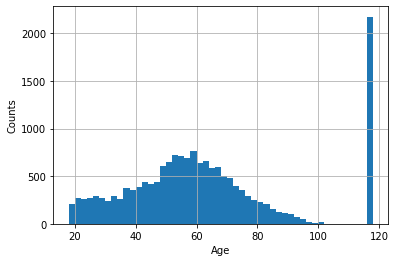

In [14]:
# Check age distribution
profile.age.hist(bins=50)
plt.xlabel('Age')
plt.ylabel('Counts');

While 118 is a possible profile age, this value is an outlier in the distribution. There are no ages between 101 and 118. Based on the distribution, and this age gap, I'm going to assume this is user input error and replace this value with NaN in the cleaning section.

### Clean Profile Data
* **Drop rows with missing age, gender, and income**
* **Replace 'age' value of 118 to NaN**
* **Transform 'date' from int to datetime dtype**
* **Convert 'became_member_on' to datetime format**
* **Rename 'id' column to 'customer_id'**
* **Create columns for gender using dummy variables**

In [15]:
# Clean profile dataframe
def cln_profile(profile):
    ''' Clean profile df
    INPUT:
    profile - profile dataset
    
    RETURNS:
    profile_cln - clean dataset
    '''
    
    # Copy profile df
    profile_cln = profile.copy()
    
    # Drop rows with missing age, gender, and income
    profile_cln = profile.drop(profile[profile['gender'].isnull()].index)

    # Replace 'age' value of 118 to NaN
    profile_cln.age.replace(118, np.nan, inplace=True)
    
    # Transform date from int to datetime
    date = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
    profile_cln.became_member_on = profile_cln.became_member_on.apply(date)
    
    # Rename 'id' column to 'customer_id'
    profile_cln.rename(columns={'id':'customer_id'}, inplace=True)
    
    # Create dummy columns for the gender column
    dummy_gender = pd.get_dummies(profile_cln.gender, prefix='gender')
    profile_cln = pd.concat([profile_cln, dummy_gender], axis=1, sort=False)
    
    return profile_cln

# Show cleaned profile df
profile_cln = cln_profile(profile)
profile_cln.head()

,gender,age,customer_id,became_member_on,income,gender_F,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0


In [16]:
# Check for duplicates
profile_cln.duplicated().sum()

0

### Assess Transcript Data

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


* 'person' column can be renamed to 'customer_id'
* 'value' column can be separated by offer and transaction number

In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [19]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [20]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

* Offer and transaction data can be separated here

### Clean Transcript Data
* **Rename 'person' column to 'customer_id'**
* **Split 'value' column to create columns for offer_id and amount**
* **Split 'event' column to create columns based on offer and transaction**
* **Drop customer_id values that are absent in the Profile dataset** 
* **Drop duplicates** 

In [21]:
# Clean transcript dataset
def cln_transcript(transcript):
    ''' Clean transcript df
    INPUT:
    transcript - profile dataframe
    
    RETURNS:
    transcript_cln - clean dataframe
    '''
    
    # Copy Transcript df
    transcript_cln = transcript.copy()
    
    # Split 'event' into separate columns using dummy variables
    transcript_cln.event = transcript_cln.event.str.replace(' ', '_')
    dummy_event = pd.get_dummies(transcript_cln.event, prefix='event')
    transcript_cln = pd.concat([transcript_cln, dummy_event], axis=1, sort=False)
    transcript_cln.drop(columns='event', inplace=True)
    
    # Extract offer data from 'value' column
    transcript_cln['offer_id'] = [[*v.values()][0]
                                   if [*v.keys()][0] in ['offer id', 'offer_id'] else None
                                   for v in transcript_cln.value]
    
    # Extract transaction amounts from 'value' column
    transcript_cln['amount'] = [np.round([*v.values()][0], decimals=2)
                                 if [*v.keys()][0] == 'amount' else None
                                 for v in transcript_cln.value]
    transcript_cln.drop(columns='value', inplace=True)
    
    # Rename 'person' to 'customer_id'
    transcript_cln.rename(columns={'person':'customer_id'}, inplace=True)
    
    # Drop customer_id values that are absent in the profile dataset
    transcript_cln = transcript_cln[transcript_cln.customer_id.isin(profile_cln.customer_id)]
    
    # Drop duplicates and reset index
    transcript_cln.drop_duplicates(inplace=True)
    transcript_cln.reset_index(drop=True, inplace=True)
  
    return transcript_cln   

# Show cleaned transcript df
transcript_cln = cln_transcript(transcript)
transcript_cln.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [22]:
# Check duplicates
transcript_cln.duplicated().sum()

0

In [23]:
# Confirm changes
transcript_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            272388 non-null  object 
 1   time                   272388 non-null  int64  
 2   event_offer_completed  272388 non-null  uint8  
 3   event_offer_received   272388 non-null  uint8  
 4   event_offer_viewed     272388 non-null  uint8  
 5   event_transaction      272388 non-null  uint8  
 6   offer_id               148431 non-null  object 
 7   amount                 123957 non-null  float64
dtypes: float64(1), int64(1), object(2), uint8(4)
memory usage: 9.4+ MB


### Merge cleaned dataframes for exploratory data analysis

In [24]:
# There are different offer ids, let's see what these are
transcript_cln.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '2906b810c7d4411798c6938adc9daaa5',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '3f207df678b143eea3cee63160fa8bed',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '5a8bc65990b245e5a138643cd4eb9837', None], dtype=object)

Looks like there are 10 types of offer ids

In [25]:
# Identify 'offer_id' associated with 'offer_type' to rename in merged df
portfolio_cln.loc[:,['offer_id','offer_type']]

,offer_id,offer_type
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo
2,3f207df678b143eea3cee63160fa8bed,informational
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount
6,fafdcd668e3743c1bb461111dcafc2a4,discount
7,5a8bc65990b245e5a138643cd4eb9837,informational
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo
9,2906b810c7d4411798c6938adc9daaa5,discount


In [26]:
# Merge dataframes for exploratory data analyis
# https://stackoverflow.com/questions/19851005/rename-pandas-dataframe-index
def df_cleaned(portfolio_cln, profile_cln, transcript_cln):
    ''' Merge cleaned dataframes
    INPUT:
    portfolio_cln - cleaned portfolio dataset
    profile_cln - cleaned profile dataset
    transcript_cln - cleaned transcript dataset
    
    RETURNS:
    cleaned_df - merged dataset
    '''
    
    # Merge df
    trans_prof = pd.merge(transcript_cln, profile_cln, on='customer_id', how='left')
    df = pd.merge(trans_prof, portfolio_cln, on='offer_id', how='left')
    
    # Label offer ids by offer type 
    offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo_1',
                '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo_2',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo_3',
                'f19421c1d4aa40978ebb69ca19b0e20d':'bogo_4',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7':'discount_1',
                '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount_2',
                'fafdcd668e3743c1bb461111dcafc2a4':'discount_3',
                '2906b810c7d4411798c6938adc9daaa5':'discount_4',
                '3f207df678b143eea3cee63160fa8bed':'info_1',
                '5a8bc65990b245e5a138643cd4eb9837':'info_2'}
    df.offer_id = df.offer_id.apply(lambda x: offer_id[x] if x else None)
    
    return df

# Show merged df
cleaned_df = df_cleaned(portfolio_cln, profile_cln, transcript_cln)
cleaned_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,gender,age,...,gender_M,gender_O,reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,bogo_3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,discount_4,NaN,M,68,...,1,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,bogo_4,NaN,M,65,...,1,0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,info_1,NaN,M,58,...,1,0,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,discount_1,NaN,F,61,...,0,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0


In [27]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272388 entries, 0 to 272387
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   customer_id            272388 non-null  object        
 1   time                   272388 non-null  int64         
 2   event_offer_completed  272388 non-null  uint8         
 3   event_offer_received   272388 non-null  uint8         
 4   event_offer_viewed     272388 non-null  uint8         
 5   event_transaction      272388 non-null  uint8         
 6   offer_id               148431 non-null  object        
 7   amount                 123957 non-null  float64       
 8   gender                 272388 non-null  object        
 9   age                    272388 non-null  int64         
 10  became_member_on       272388 non-null  datetime64[ns]
 11  income                 272388 non-null  float64       
 12  gender_F               272388 non-null  uint

<a id='eda'></a>
# 3. Exploratory Data Analysis

### Duration of experiment and number of events collected

In [28]:
# Duration of experiment in hours
cleaned_df.time.max()

714

In [29]:
# Duration of experiment in days
cleaned_df.time.max()/24

29.75

In [30]:
# Number of events collected in experiment
cleaned_df.shape

(272388, 23)

The experiment was run for 29 days and 272,388 collected events are included in this analysis.

### Number and type of promotions sent to users during the experiment

In [31]:
# Number and type of offers sent to users
cleaned_df.offer_type.value_counts()

bogo             63676
discount         62095
informational    22660
Name: offer_type, dtype: int64

In [32]:
# Number of promotions by offer id
cleaned_df.offer_id.value_counts()

discount_3    18016
discount_2    17881
bogo_4        16960
bogo_2        16203
bogo_1        16188
bogo_3        14325
discount_4    13951
info_2        12516
discount_1    12247
info_1        10144
Name: offer_id, dtype: int64

<a id='offer'></a>
## i. Offer Types & IDs Distributed to Users During Experiment

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

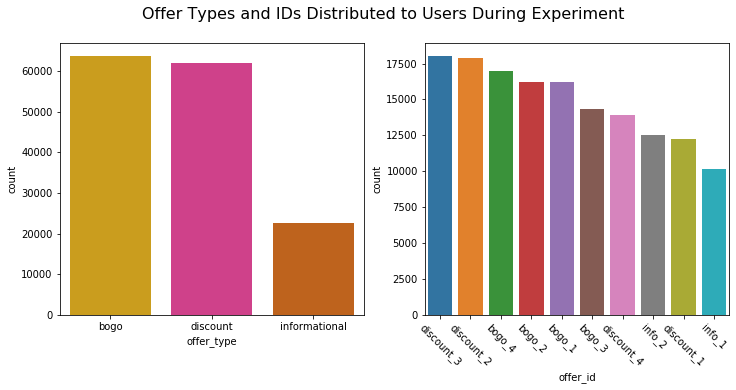

In [33]:
# Plotting offer types & IDs sent to users during experiment
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.suptitle('Offer Types and IDs Distributed to Users During Experiment', size = 16)

sns.countplot(x='offer_type', data = cleaned_df, ax = ax[0], palette='Dark2_r');

sns.countplot(x='offer_id', data = cleaned_df, order = cleaned_df['offer_id'].value_counts(ascending=False).index, ax = ax[1])
plt.xticks(rotation=-45)

>* BOGO (buy-one-get-one) was the most distributed promotion with 63,676 users receiving this special. Discount promotions were the second most advertised (62,095) and informational offers were the least common (22,660).
>* When looking at distribution of promotions based on offer id, discount_3 was the most common (18,016) followed by discount_2 (17,881), and the BOGOs (bogo_4 (16,960), bogo_2 (16,203), bogo_1 (16,188), and bogo_3 (14,325)). The least common promotion was info_1 at 10,144.

### Explore transaction, offer, and demographic data per customer 

**Build a dataframe with aggregated transaction, offer, and demographics data for customer behavior analysis.**
* The following steps were taken to build the customer dataframe:
    1. Get offer type data per customer
    2. Get offer id data per customer
    3. Group age and income for better visualization/distribution
    4. Build a dataframe by merging extracted variables, demographics, offers, and transaction data

**1. Get offer type data per customer**

In [63]:
# Get offer data (received, viewed and completed) per customer by offer type
# https://stackoverflow.com/questions/41118359/aggregate-values-in-dictionary-by-key
def cust_offer_type(cleaned_df, offer_type=None):
    ''' Get offer data (received, viewed and completed) per customer by offer type
    INPUT:
    cleaned_df - merged transactions, portfolio, and profile datasets
    offer_type - bogo, discount, informational
    
    RETURNS:
    offer_type_cust - offer type data (received, viewed and completed) per customer
    '''
    # Define dict
    data = dict()
    for e in ['received', 'viewed', 'completed']:  
        # Get 'completed' data for informational offers 
        if offer_type == 'informational' and e == 'completed':
            continue
        flag = (cleaned_df['event_offer_{}'.format(e)] == 1)
        key = e
        if offer_type:
            flag = flag & (cleaned_df.offer_type == offer_type)
            key = '{}_'.format(offer_type) + key
        data[key] = cleaned_df[flag].groupby('customer_id').offer_id.count()
        # Get 'reward' data for informational offers 
        flag = (cleaned_df.event_offer_completed == 1)
        if offer_type != 'informational':
            key = 'reward'
            if offer_type:
                flag = flag & (cleaned_df.offer_type == offer_type)
                key = '{}_'.format(offer_type) + key
            data[key] = cleaned_df[flag].groupby('customer_id').reward.sum()

    return data

**2. Get offer id data per customer**

In [64]:
# Get offer data (received, viewed and completed) per customer by offer id
def cust_offer_id(cleaned_df, offer_id):
    ''' Get offer data (received, viewed and completed) per customer by offer id
    INPUT:
    cleaned_df - merged transactions, portfolio, and profile datasets
    offer_id - 'bogo_1','bogo_2','bogo_3','bogo_4','discount_1','discount_2','discount_3','discount_4','info_1','info_2'
    
    RETURNS:
    cust_offer_id - offer id data per customer
    '''
    
    data = dict()

    for e in ['received', 'viewed', 'completed']:
        # Get 'completed' data for informational offers
        if offer_id in ['info_1', 'info_2'] and e == 'completed':
            continue
        event = 'event_offer_{}'.format(e)
        flag = (cleaned_df[event] == 1) & (cleaned_df.offer_id == offer_id)
        key = '{}_{}'.format(offer_id, e)
        data[key] = cleaned_df[flag].groupby('customer_id').offer_id.count()

        # Get 'reward' data for informational offers
        flag = (cleaned_df.event_offer_completed == 1) & (cleaned_df.offer_id == offer_id)
        if offer_id not in ['info_1', 'info_2']:
            key = '{}_reward'.format(offer_id)
            data[key] = cleaned_df[flag].groupby('customer_id').reward.sum()

    return data

**3. Group age and income for better visualization/distribution**

In [65]:
# Group income by rounding to the lower 10000th
# https://stackoverflow.com/questions/46481351/how-to-round-numbers-to-the-nearest-1000
def group_income(x):
    ''' Round income to the lower 10000th
    INPUT:
    x - income
    
    RETURNS:
    rounded_income - returns 0 if the income is less than 30,000 or greater than 120,000
    '''
    for y in range(30, 130, 10):
        if x >= y*1000 and x < (y+10)*1000:
            return y*1000   
    return 0

# Group age by rounding to the 5th of each 10th 
def group_age(x):
    ''' Round age to the 5th of each 10th (15, 25,..., 105)
    INPUT:
    x - age
    
    RETURNS:
    rounded_age - returns 0 if the value is less than 15 or greater than 105
    '''
    for y in range(15, 106, 10):
        if x >= y and x < y+10:
            return y
    return 0

**4. Build a dataframe with aggregated demographics, offers, and transaction data**

In [66]:
# Build customer dataframe with aggregated purchase data, offer data, and demographic data
def merged_cust(cleaned_df, profile_cln):
    ''' Build a dataframe with aggregated purchase and offer data and demographics
    INPUT:
    cleaned_df - merged transactions, portfolio, and profile datasets
    
    RETURNS:
    merged_cust - df with aggregated customer data
    '''
    
    cust_dict = dict()
    
    # Get total transaction data
    transactions = cleaned_df[cleaned_df.event_transaction == 1].groupby('customer_id')
    cust_dict['total_expense'] = transactions.amount.sum()
    cust_dict['total_transactions'] = transactions.amount.count()
    
    # Get aggregate offer data
    cust_dict.update(cust_offer_type(cleaned_df))
    
    # Get offer type data
    for ot in ['bogo', 'discount', 'informational']:
        cust_dict.update(cust_offer_type(cleaned_df, ot))
    
    # Get offer id data
    for oi in ['bogo_1','bogo_2','bogo_3','bogo_4',
               'discount_1','discount_2','discount_3','discount_4',
               'info_1','info_2']:
        cust_dict.update(cust_offer_id(cleaned_df, oi))

    # Build df, aggregate dict values and demographic data
    merged_cust = pd.concat(cust_dict.values(), axis=1, sort=False);
    merged_cust.columns = cust_dict.keys()
    merged_cust.fillna(0, inplace=True)
    merged_cust = pd.merge(merged_cust, profile_cln.set_index('customer_id'),
                         left_index=True, right_index=True)
    
    # Add columns for net expense, age, and income groups 
    merged_cust['age_group'] = merged_cust.age.apply(group_age)
    merged_cust['income_group'] = merged_cust.income.apply(group_income)
    merged_cust['net_expense'] = merged_cust['total_expense'] - merged_cust['reward']

    return merged_cust

# Show merged df
merged_cust = merged_cust(cleaned_df, profile_cln)
merged_cust.head()

,total_expense,total_transactions,received,reward,viewed,completed,bogo_received,bogo_reward,bogo_viewed,bogo_completed,...,gender,age,became_member_on,income,gender_F,gender_M,gender_O,age_group,income_group,net_expense
0009655768c64bdeb2e877511632db8f,127.60,8.0,5.0,9.0,4.0,3.0,1.0,5.0,1.0,1.0,...,M,33,2017-04-21,72000.0,0,1,0,25,70000,118.60
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5.0,13.0,5.0,3.0,1.0,5.0,1.0,1.0,...,O,40,2018-01-09,57000.0,0,0,1,35,50000,66.46
0020c2b971eb4e9188eac86d93036a77,196.86,8.0,5.0,14.0,3.0,3.0,2.0,10.0,1.0,1.0,...,F,59,2016-03-04,90000.0,1,0,0,55,90000,182.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0,4.0,13.0,4.0,3.0,2.0,10.0,2.0,2.0,...,F,24,2016-11-11,60000.0,1,0,0,15,60000,141.05
003d66b6608740288d6cc97a6903f4f0,48.34,18.0,5.0,9.0,4.0,3.0,0.0,0.0,0.0,0.0,...,F,26,2017-06-21,73000.0,1,0,0,25,70000,39.34


In [67]:
merged_cust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 0009655768c64bdeb2e877511632db8f to ffed75d3abc64b488982f50ed12878b5
Data columns (total 62 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_expense           14825 non-null  float64       
 1   total_transactions      14825 non-null  float64       
 2   received                14825 non-null  float64       
 3   reward                  14825 non-null  float64       
 4   viewed                  14825 non-null  float64       
 5   completed               14825 non-null  float64       
 6   bogo_received           14825 non-null  float64       
 7   bogo_reward             14825 non-null  float64       
 8   bogo_viewed             14825 non-null  float64       
 9   bogo_completed          14825 non-null  float64       
 10  discount_received       14825 non-null  float64       
 11  discount_reward         14825 non-null  float64      

### Explore and visualize trends in customer dataframe

In [68]:
# Observe correlations to explore specific variables
merged_cust.corr().style.background_gradient(cmap='coolwarm')

>This heatmap suggests that offer completions have some correlation with spending habits of customers. Gender and income also seem to be correlated with purchasing habits.

### Variable distribution in customer dataset

(array([0.0e+00, 5.0e-06, 1.0e-05, 1.5e-05, 2.0e-05, 2.5e-05]),
 <a list of 6 Text yticklabel objects>)

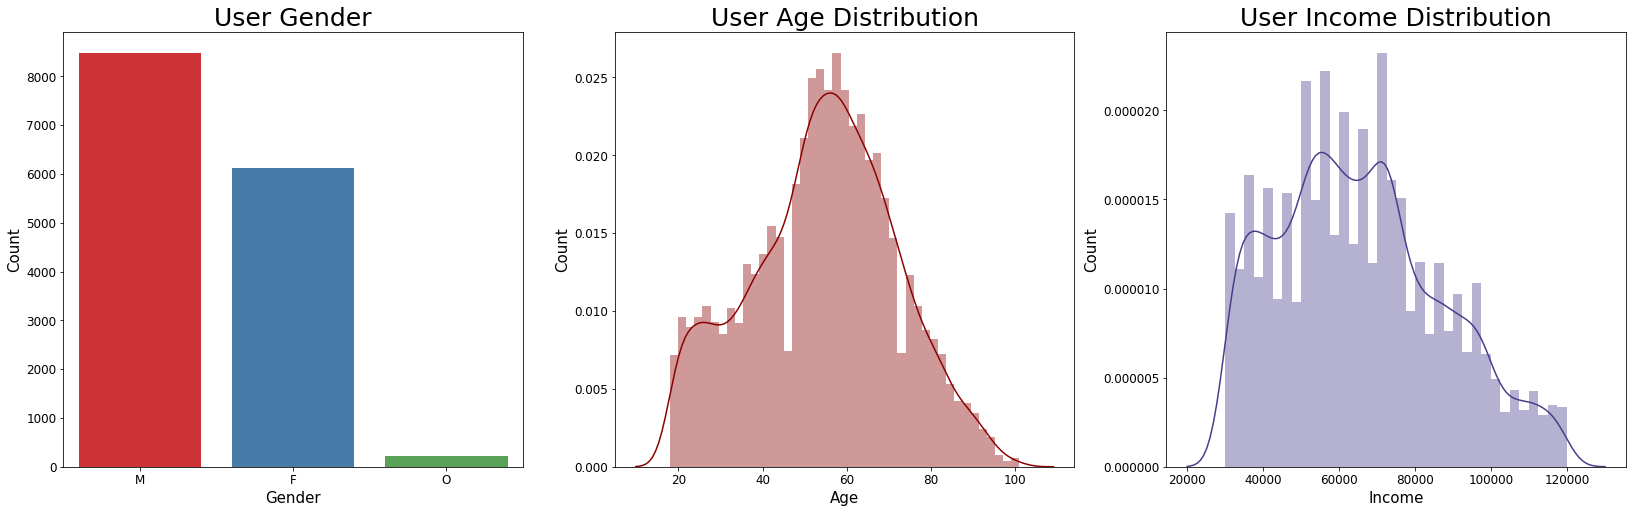

In [69]:
# Plot customer df variable distributions for trend analysis
# Set environment to display 3 subplots
fig, ax = plt.subplots(figsize=(28, 8), nrows=1, ncols=3)

# Plot user genders 
plt.sca(ax[0])
sns.countplot(x='gender', data=merged_cust, order=merged_cust['gender'].value_counts(ascending=False).index, palette='Set1')
plt.xlabel('Gender', size = 15)
plt.ylabel('Count', size = 15)
plt.title('User Gender', size = 25)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Plot age distribution
plt.sca(ax[1])
sns.distplot(merged_cust['age'], color='darkred')
plt.xlabel('Age', size = 15)
plt.ylabel('Count', size = 15)
plt.title('User Age Distribution', size = 25)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Income distribution plot
plt.sca(ax[2])
sns.distplot(merged_cust['income'], color='darkslateblue')
plt.xlabel('Income', size = 15)
plt.ylabel('Count', size = 15)
plt.title('User Income Distribution', size = 25)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

>The dataset contains 8,484 males, 6,129 females, and 212 users of 'other' gender. The most common age of users in this dataset is 50-70 years. Majority of users in the dataset have incomes within the 55,000-78,000 range.

<a id='gender'></a>
## ii. Gender Distribution & Average Spending

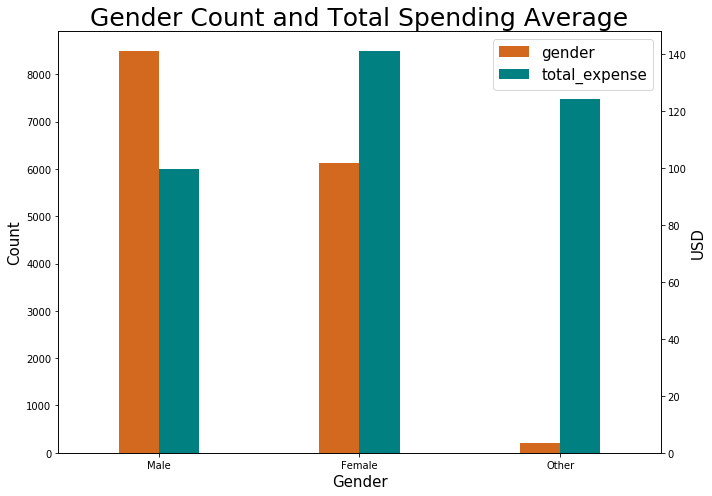

In [70]:
# Combine gender count and spending plots 
# Create matplotlib figure
fig = plt.figure(figsize=(10,7))

# Create matplotlib axes
ax = fig.add_subplot(111) 

# Create another axes that shares the same x-axis as ax.
ax2 = ax.twinx()

width = 0.20

# Plot gender count and spending by gender
merged_cust.gender.value_counts().plot(kind='bar', color='chocolate', ax=ax, width=width, position=1, rot=0)
merged_cust.groupby('gender').total_expense.mean().reindex(['M', 'F', 'O']).plot(kind='bar', color='teal', ax=ax2, width=width, position=0)

# Setting xlim within age range and spending
plt.xlim(right= 2.5) 
plt.xlim(left= -0.5)

# Setting labels
ax.set_ylabel('Count', size = 15)
ax2.set_ylabel('USD', size = 15)
ax.set_xlabel('Gender', size = 15)
plt.title('Gender Count and Total Spending Average', size = 25)

# Renaming x tick marks
group_labels = ['Male', 'Female', 'Other']
ax.set_xticklabels(group_labels)

# Making legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# Add legend
plt.legend(lines, labels, loc='upper right', bbox_transform = plt.gcf().transFigure, fontsize='15')
plt.tight_layout()

>The dataset contains 8,484 males, 6,129 females, and 212 users of 'other' gender. While the majority of users are males, females spend more with average expenses totalling to 140.91 USD. Total spending average for other genders is 124.32 USD and 99.59 USD and for males.

<a id='age'></a>
## iii. Age Distribution & Average Spending

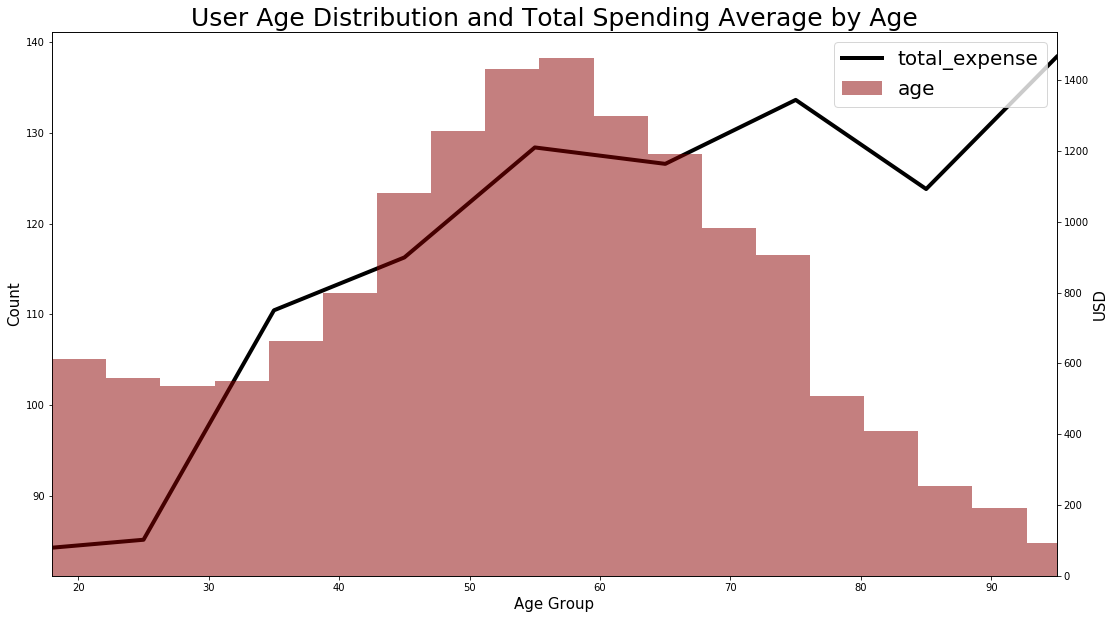

In [71]:
# Combine age count distribution and average spending by age
fig, ax = plt.subplots(figsize=(18, 10))
ax2 = ax.twinx()

# Setting xlim within age range and spending
plt.xlim(right=95) 
plt.xlim(left=18)

# Define age_groupby
age_groupby = merged_cust[(merged_cust.income_group > 0)].groupby('age_group')

# Plot line graph spending average by age
ax = age_groupby.total_expense.mean().reindex(range(15, 96, 10)).plot(kind='line', rot=0, ax=ax, linewidth=4.0, color='black')

# Plot hist age count distribution
ax2 = merged_cust.age.plot(kind='hist', ax=ax2, range=[18, 101], alpha=0.5, bins = 20, color='darkred')

# Labeling
ax.set_ylabel('Count', size = 15)
ax.set_xlabel('Age Group', size = 15)
ax2.set_ylabel('USD', size = 15)
plt.title('User Age Distribution and Total Spending Average by Age', size = 25)

# Making legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# Add legend
plt.legend(lines, labels, loc='upper right', bbox_transform = plt.gcf().transFigure, fontsize='20')


> Majority of users in this dataset are within the 50-70 year age group. As age increases, users spend more.

<a id='income'></a>
## iv. Income Distribution & Average Spending

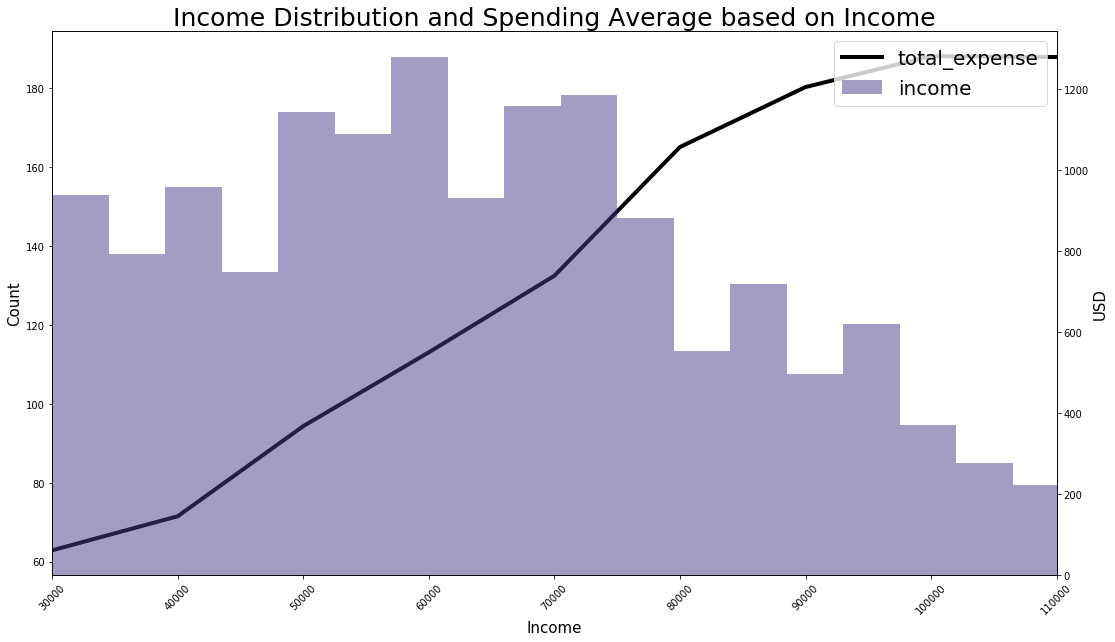

In [72]:
# Combine income distribution histogram and spending by income line plot
fig, ax = plt.subplots(figsize=(18, 10))
ax2 = ax.twinx()

# Setting xlim within age range and spending
plt.xlim(right=110000) 
plt.xlim(left=30000)

# Define income_groupby
income_groupby = merged_cust[(merged_cust.income_group > 0)].groupby('income_group')

# Plot line
ax = income_groupby.total_expense.mean().reindex(range(30000, 111000,10000)).plot(kind='line', rot=45, ax=ax, linewidth=4.0, style='black')

# Plot hist
ax2 = merged_cust[merged_cust.income_group > 0].income.plot(kind='hist', ax=ax2, alpha=0.5, bins = 20, color='darkslateblue')

# Labeling
ax.set_ylabel('Count', size = 15)
ax.set_xlabel('Income', size = 15)
ax2.set_ylabel('USD', size = 15)
plt.title('Income Distribution and Spending Average based on Income', size = 25)

# Making legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# Add legend
plt.legend(lines, labels, loc='upper right', bbox_transform = plt.gcf().transFigure, fontsize='20')

> The 55,000-78,000 salary range most common in the dataset. Users with greater income spend more. 

<a id='visuals'></a>
# 4. Data Visualization

<a id='spending'></a>
## i. Spending Patterns by Offer Type & Demographics

**Build dataframe to analyze customer spending behavior:**
1. Aggregate data for customers that:
    * received --> not viewed offer
    * viewed --> not completed offer
    * viewed --> completed offer
2. Get the average expense for customers that:
    * received --> not viewed offer
    * viewed --> not completed offer
    * viewed --> completed offer
3. Plot the average expense per transaction for customers that:
    * received --> not viewed offer
    * viewed --> not completed offer
    * viewed --> completed offer
    
   Separate by age, income, and gender

**1. Aggregate data for customers that: received --> not viewed offer, viewed --> not completed offer, viewed --> completed offer**

In [73]:
# Get any column for customers that received but not viewed an offer, viewed but not completed the offer, and those that viewed and completed the offer, grouped by a column
# https://stackoverflow.com/questions/25740726/how-to-aggregate-elements-of-a-list-of-tuples-if-the-tuples-have-the-same-first
def offer_status(merged_cust, stat, offer, by_col, aggr='sum'): 
    ''' Get any column for customers that received but not viewed an offer, viewed but not completed the offer, and those that viewed and completed the offer, grouped by a column 
    INPUT:
    merged_cust - aggregated offer and demographic df
    stat - column of interest
    offer - offer of interest
    by_col - column used to group the data
    aggr - aggregation method sum or mean
    
    RETURNS:
    (received_agg, viewed_agg, completed) - tuple with sum aggregation
    '''
   
    # Define dict
    received_col = '{}_received'.format(offer)
    viewed_col = '{}_viewed'.format(offer)
    received = (merged_cust[received_col] > 0) & (merged_cust[viewed_col] == 0)
    completed = None
    # Aggregate customer behavior data for schema
    if offer not in ['informational', 'info_1', 'info_2']:
        completed_col = '{}_completed'.format(offer)
        viewed = (merged_cust[viewed_col] > 0) & (merged_cust[completed_col] == 0)
        completed_off = (merged_cust[completed_col] > 0)
        if aggr == 'sum':
            completed = merged_cust[completed_off].groupby(by_col)[stat].sum()
        elif aggr == 'mean':
            completed = merged_cust[completed_off].groupby(by_col)[stat].mean()
    else:
        viewed = (merged_cust[viewed_col] > 0)
    if aggr == 'sum':
        received_agg = merged_cust[received].groupby(by_col)[stat].sum()
        viewed_agg = merged_cust[viewed].groupby(by_col)[stat].sum()
    elif aggr == 'mean':
        received_agg = merged_cust[received].groupby(by_col)[stat].mean()
        viewed_agg = merged_cust[viewed].groupby(by_col)[stat].mean()
    return received_agg, viewed_agg, completed

**2. Get the average expense for customers that: received --> not viewed offer, viewed --> not completed offer, viewed --> completed offer**

In [74]:
# Get the average expense for customers that received but not viewed an offer, viewed but not completed the offer, and those that viewed and completed the offer, group by a column 
def avg_expense(merged_cust, offer, by_col): 
    ''' Get the average expense for customers that received but not viewed an offer, viewed but not completed the offer, and those that viewed and completed the offer, group by a column 
    INPUT:
    merged_cust - aggregated offer and demographic df
    offer - offer of interest
    by_col - column used to group the data
    
    RETURNS:
    (received, viewed, completed) - tuple with the average expense
    '''
    # Get totals
    received_total, viewed_total, completed_total = offer_status(merged_cust,
                                                        'total_expense',
                                                        offer, by_col)
    received_trans, viewed_trans, completed_trans = offer_status(merged_cust,
                                                        'total_transactions',
                                                        offer, by_col)
    # Calculate averages for received and viewed offers
    received_avg = received_total / received_trans
    received_avg.fillna(0, inplace=True)
    viewed_avg = viewed_total / viewed_trans
    viewed_avg.fillna(0, inplace=True)
    completed_avg = None
    if offer not in ['informational', 'info_1', 'info_2']:
        completed_avg = completed_total / completed_trans

    return received_avg, viewed_avg, completed_avg

**3. Plot the average expense per transaction for customers that: received --> not viewed offer, viewed --> not completed offer, viewed --> completed offer**

**Separate by age, income, and gender**

In [75]:
# Plot the total expense and the average expense per transaction incurred by customers that have received, viewed and completed an offer.
# https://stackoverflow.com/questions/37978542/plot-multiple-functions-with-the-same-properties-in-matplotlib
def offer_earnings_plot(merged_cust, offer):
    ''' Plot the average expense per transaction for customersthat have received, viewed and completed an offer.
    INPUT:
    merged_cust - customer df
    offer - offer type
    
    RETURNS:
    (age, incomme, and gender) - plots
    '''  
    # Set palette
    plt.rcParams["image.cmap"] = "Set1"
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
    
    # Define variables
    received_by = dict()
    viewed_by = dict()
    completed_by = dict()
    received_avg_by = dict()
    viewed_avg_by = dict()
    completed_avg_by = dict()

    # Aggregate data by age, income, and gender
    for key in ['age_group', 'income_group', 'gender']:
        received_by[key], viewed_by[key], completed_by[key] = offer_status(merged_cust,
                                                                  'net_expense',
                                                                  offer, key,
                                                                  aggr='mean')
        by = avg_expense(merged_cust, offer, key)
        received_avg_by[key], viewed_avg_by[key], completed_avg_by[key] = by
    
    # Plot layout
    plt.figure(figsize=(16, 10))

    # Plot offer expense by 'bogo'
    plt.subplot(231)
    plt.plot(received_avg_by['age_group'], label='{}-received'.format(offer))
    plt.plot(viewed_avg_by['age_group'], label='{}-viewed'.format(offer))
    if offer not in ['informational', 'info_1', 'info_2']:
        plt.plot(completed_avg_by['age_group'], label='{}-completed'.format(offer))
    plt.legend(loc='upper left')
    plt.title('Average Transaction Value by Age')
    plt.xlabel('Age')
    plt.ylabel('USD');

    # Plot offer expense by 'discount'
    plt.subplot(232)
    plt.plot(received_avg_by['income_group'], label='{}-received'.format(offer))
    plt.plot(viewed_avg_by['income_group'], label='{}-viewed'.format(offer))
    if offer not in ['informational', 'info_1', 'info_2']:
        plt.plot(completed_avg_by['income_group'], label='{}-completed'.format(offer))
    plt.legend(loc='upper left')
    plt.title('Average Transaction Value by Income')
    plt.xlabel('Income')
    plt.ylabel('USD');
   
    # Plot offer expense by 'informational'
    plt.subplot(233)
    index = np.array([0, 1, 2])
    bar_width = 0.3
    plt.bar(index, received_avg_by['gender'].reindex(['M', 'F', 'O']), bar_width,
            label='{}-received'.format(offer))
    plt.bar(index + bar_width, viewed_avg_by['gender'].reindex(['M', 'F', 'O']),
            bar_width, label='{}-viewed'.format(offer))
    if offer not in ['informational', 'info_1', 'info_2']:
        plt.bar(index+2*bar_width, completed_avg_by['gender'].reindex(['M', 'F', 'O']),
                bar_width, label='{}-completed'.format(offer))
    plt.legend(loc='upper left')
    plt.title('Average Transaction Value by Gender')
    plt.xticks(index + bar_width, ('Male', 'Female', 'Other'))
    plt.xlabel('Gender')
    plt.ylabel('USD');

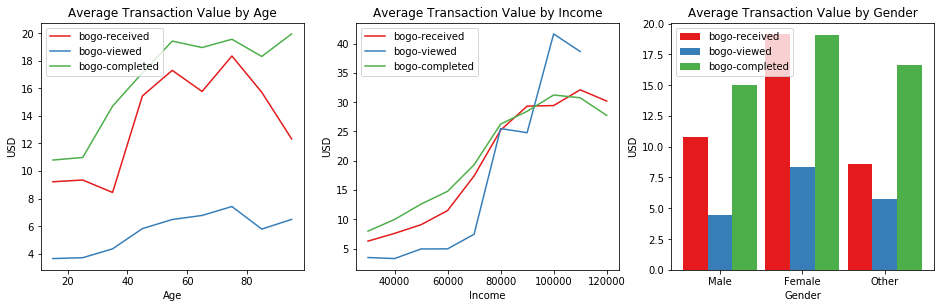

In [76]:
# Plot bogo offer earnings
offer_earnings_plot(merged_cust, 'bogo')

> * With increasing age, the BOGO offer is completed at a higher transaction value
> * Users with greater income redeem spend more money when redeeming BOGO offers 
> * Females spend the most per transaction with BOGO offers 

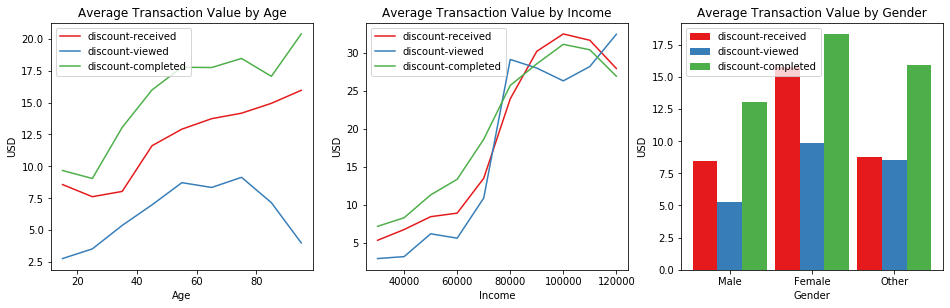

In [78]:
# Plot discount offer earnings
offer_earnings_plot(merged_cust, 'discount')

> * Users above 70 years view discounts less frequently 
> * Average transaction value is for viewed and completed discounts is greater with increasing age
> * Transaction values for discount offers increases with greater income
> * Females have the greatest transaction value for discount offers. 

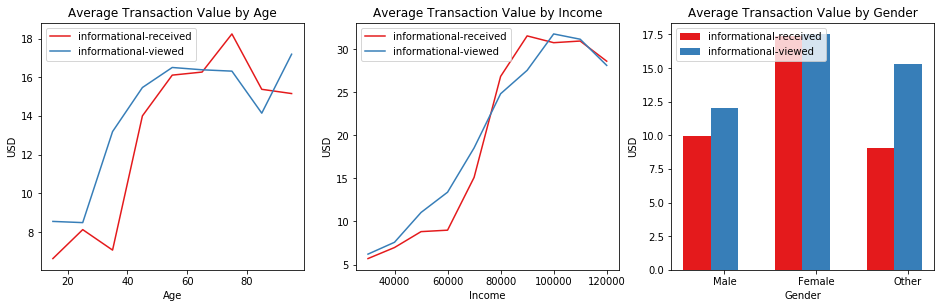

In [79]:
# Plot informational offer earnings
offer_earnings_plot(merged_cust, 'informational')

> * Average transaction value for informational offers increases from ages 35-75 and declines between 75-80 years before increasing slighltly
> * Transaction value increases with greater salaries and begins to decline beyond 90,000 USD
> * Females have spend more per transaction than males and other genders for informational offers

> * The spending patterns are similar for customers that received, viewed and completed offers. 

<a id='top'></a>
## ii. Top 10 Offers

**Getting most popular offers:**
1. Get the net earnings for customers that viewed and completed offers
2. Sort offers by highest earnings

**1. Get the net_expense for customers that viewed and completed offers**

In [80]:
# Get the net earnings for customers that viewed and completed offers
# https://towardsdatascience.com/uplift-modeling-e38f96b1ef60
# https://www.geeksforgeeks.org/python-pandas-dataframe-quantile/
def net_earnings(merged_cust, offer, q=0.5):  
    '''Get the net_earnings for customers that viewed and completed offers 
    INPUT:
    offer - offer of interest
    q - quantile to be used
    
    RETURNS:
    net_earnings - median of total transaction value
    '''
    # Flag customers that viewed offers
    flag = (merged_cust['{}_viewed'.format(offer)] > 0)
    # Sort through positive net earnings
    flag = flag & (merged_cust.net_expense > 0)
    # Aggregate those with at least 5 transactions
    flag = flag & (merged_cust.total_transactions >= 5)
    # Aggregate viewed and completed offers
    if offer not in ['info_1', 'info_2']:
        flag = flag & (merged_cust['{}_completed'.format(offer)] > 0)
    return merged_cust[flag].net_expense.quantile(q)

**2. Sort offers by highest earnings**

In [81]:
# Define loop that sorts by highest earnings
def greatest_earnings(merged_cust, n_top=2, q=0.5, offers=None):
    '''Sort offers based on the ones that result in the highest net_expense
    INPUT:
    customers - dataframe with aggregated data of the offers
    n_top - number of offers to be returned (default: 2)
    q - quantile used for sorting
    offers - list of offers to be sorted
    
    RETURNS:
    sorted list of offers, in descending order according to the median net_expense
    '''
    # Sort for offers earnings in second quantile
    if not offers:
        offers = ['bogo_1','bogo_2','bogo_3','bogo_4',
               'discount_1','discount_2','discount_3','discount_4',
               'info_1','info_2']
    offers.sort(key=lambda x: net_earnings(merged_cust, x, q), reverse=True)
    offers_dict = {o: net_earnings(merged_cust, o, q) for o in offers}
    return offers[:n_top], offers_dict

In [82]:
# Print 10 offers by most to least popular, highest to least highest earnings
offers = greatest_earnings(merged_cust, n_top=10)
print(offers[0])
print(offers[1])

['bogo_1', 'bogo_2', 'discount_1', 'discount_4', 'discount_3', 'bogo_3', 'bogo_4', 'discount_2', 'info_1', 'info_2']
{'bogo_1': 145.7, 'bogo_2': 145.685, 'discount_1': 145.53000000000003, 'discount_4': 138.16000000000003, 'discount_3': 131.97, 'bogo_3': 131.25, 'bogo_4': 131.07, 'discount_2': 125.25000000000003, 'info_1': 124.20000000000002, 'info_2': 103.285}


> * The 'bogo_1' offer returned the greatest value of 145.7 USD in earnings per customer. The 'bogo_2' (145.69 USD) and 'discount_1' (145.53 USD) offers fall in second and third respectively. The least successful offer was 'info_2' which returned 103.29 USD per customer.

Averages:
* BOGO 138.43 USD
* Discounts 135.23 USD
* Informational 113.74 USD

<a id='percent'></a>
## iii. Percent Success by Offer

**Calculate percent success**

In [85]:
# Calculate percent success by offer
# https://stackoverflow.com/questions/5997987/is-there-an-operator-to-calculate-percentage-in-python
def calculate_percentage_success():
    '''Calculate percent success by offer
    INPUT:
    cleaned_df - dataframe with merged transaction, offer, and demographic data
    
    RETURNS:
    percent success by offer
    '''
    # Define variables, calculate percent success
    successful_count = cleaned_df[['offer_id', 'event_offer_completed']].groupby(
        'offer_id').sum().reset_index()
    offer_count = cleaned_df['offer_id'].value_counts()
    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])
    successful_count = successful_count.sort_values('offer_id')
    offer_count = offer_count.sort_values('offer_id')
    percent_success = pd.merge(offer_count, successful_count, on="offer_id")
    percent_success['percent_success'] = (100 * percent_success['event_offer_completed'] / percent_success['count'])
    percent_success = percent_success.drop(columns=['event_offer_completed'])
    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [86]:
percent_success = calculate_percentage_success()
percent_success

,offer_id,count,percent_success
0,bogo_3,14325,28.907504
1,discount_4,13951,27.668268
2,discount_3,18016,27.514432
3,discount_2,17881,27.106985
4,discount_1,12247,26.994366
5,bogo_4,16960,24.021226
6,bogo_1,16188,22.263405
7,bogo_2,16203,20.249337
8,info_1,10144,0.000000
9,info_2,12516,0.000000


There's no way to tell whether informational offers are completed, which is why percent success is zero. For this reason, will be dropping these columns from df for analysis.

In [87]:
# Removing informational offers
percent_success = percent_success.drop(percent_success.index[[8,9]])

In [88]:
percent_success

,offer_id,count,percent_success
0,bogo_3,14325,28.907504
1,discount_4,13951,27.668268
2,discount_3,18016,27.514432
3,discount_2,17881,27.106985
4,discount_1,12247,26.994366
5,bogo_4,16960,24.021226
6,bogo_1,16188,22.263405
7,bogo_2,16203,20.249337


[Text(0, 0, 'bogo_3'),
 Text(0, 0, 'discount_4'),
 Text(0, 0, 'discount_3'),
 Text(0, 0, 'discount_2'),
 Text(0, 0, 'discount_1'),
 Text(0, 0, 'bogo_4'),
 Text(0, 0, 'bogo_1'),
 Text(0, 0, 'bogo_2')]

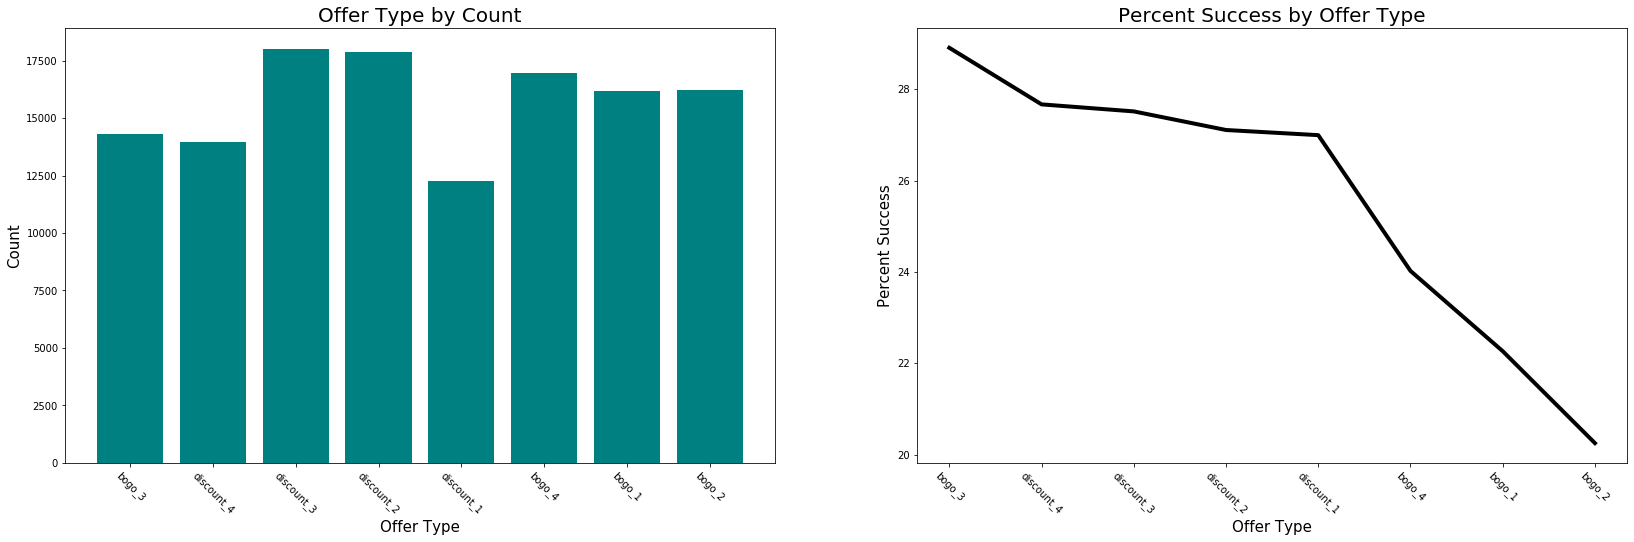

In [89]:
# Plot offer_id count and percent success
# Set up plot
fig, ax = plt.subplots(figsize=(28, 8), nrows=1, ncols=2)

# Plot offer type by count
ax[0].bar(percent_success.index + 1, percent_success['count'], color='teal')
ax[0].set_xticks(np.arange(0,8) + 1)
ax[0].set_xlabel('Offer Type',size = 15)
ax[0].set_ylabel('Count',size = 15)
ax[0].set_title('Offer Type by Count', size = 20)
# Renaming x tick marks
group_labels = ['bogo_3', 'discount_4', 'discount_3', 
                'discount_2', 'discount_1', 'bogo_4', 
                'bogo_1', 'bogo_2']
ax[0].set_xticklabels(group_labels, rotation=-45)


# Plot percent success by offer type
ax[1].plot(percent_success.index + 1, percent_success['percent_success'], linewidth=4.0, color='black')
ax[1].set_xticks(np.arange(0,8) + 1)
ax[1].set_xlabel('Offer Type',size = 15)
ax[1].set_ylabel('Percent Success',size = 15)
ax[1].set_title('Percent Success by Offer Type', size = 20)

# Renaming x tick marks
group_labels = ['bogo_3', 'discount_4', 'discount_3', 
                'discount_2', 'discount_1', 'bogo_4', 
                'bogo_1', 'bogo_2']
ax[1].set_xticklabels(group_labels, rotation=-45)

> * The 'bogo_3' offer had the greatest percent success of 28.91% followed by '	discount_4' (27.67%) and 'discount_3' (27.51%). The offer with the least percent success was 'bogo_2' at 20.25% success rate.

<a id='data'></a>
# 5. Data Preprocessing

### Creating df for modeling

In [64]:
# Checking out portfolio_clean dataset from earlier
portfolio_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reward          10 non-null     int64 
 1   difficulty      10 non-null     int64 
 2   duration        10 non-null     int64 
 3   offer_type      10 non-null     object
 4   offer_id        10 non-null     object
 5   channel_email   10 non-null     uint8 
 6   channel_mobile  10 non-null     uint8 
 7   channel_social  10 non-null     uint8 
 8   channel_web     10 non-null     uint8 
dtypes: int64(3), object(2), uint8(4)
memory usage: 568.0+ bytes


* portfolio_clean used for merged_df isn't helpful for building a model for the following reasons:
    * dtypes of 'uint8' for channel columns (need numerical values for model)
    * offer_type should be converted to numerics

**Process portfolio dataset for modeling**

In [65]:
# Clean Portfolio dataset by offer type
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
def modeling_portfolio(portfolio):
    ''' Preprocess portfolio df 
    INPUT:
    portfolio - portfolio dataset
    
    RETURNS:
    portfolio_clean - clean dataset
    '''
    # Copy portfolio df
    portfolio_modeling = portfolio.copy()
    
    # portfolio: one-hot encode channels
    for index, row in portfolio_modeling.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in portfolio_modeling.loc[index, 'channels']:
                portfolio_modeling.loc[index, channel] = 1
            else:
                portfolio_modeling.loc[index, channel] = 0
    portfolio_modeling.drop(columns='channels', inplace=True)
    
    # One-hot encode offer_type column
    for index, row in portfolio_modeling.iterrows():
        for offertype in ['bogo', 'informational', 'discount']:
            if offertype in portfolio_modeling.loc[index, 'offer_type']:
                portfolio_modeling.loc[index, offertype] = 1
            else:
                portfolio_modeling.loc[index, offertype] = 0
    portfolio_modeling.drop(columns='offer_type', inplace=True)
    
    # Rename 'id' column to 'offer_id'
    portfolio_modeling.rename(columns={'id':'offer_id'}, inplace=True)
    
    return portfolio_modeling

In [66]:
portfolio_modeling = modeling_portfolio(portfolio)
portfolio_modeling

,reward,difficulty,duration,offer_id,web,email,social,mobile,bogo,informational,discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [67]:
portfolio_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reward         10 non-null     int64  
 1   difficulty     10 non-null     int64  
 2   duration       10 non-null     int64  
 3   offer_id       10 non-null     object 
 4   web            10 non-null     float64
 5   email          10 non-null     float64
 6   social         10 non-null     float64
 7   mobile         10 non-null     float64
 8   bogo           10 non-null     float64
 9   informational  10 non-null     float64
 10  discount       10 non-null     float64
dtypes: float64(7), int64(3), object(1)
memory usage: 1008.0+ bytes


**Profile dataset**
* Convert gender to numerics
* Drop variables that aren't needed for building models

In [68]:
# Copy portfolio df
profile_modeling = profile_clean.copy()
# Convert gender to int dtype
profile_modeling['gender'] = profile_modeling['gender'].apply(lambda x: 1 if x == 'M' else 2 if x == 'F' else 0)    

In [69]:
profile_modeling.head()  

,gender,age,customer_id,became_member_on,income,gender_F,gender_M,gender_O
1,2,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
3,2,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0


In [70]:
profile_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  int64         
 1   age               14825 non-null  int64         
 2   customer_id       14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   gender_F          14825 non-null  uint8         
 6   gender_M          14825 non-null  uint8         
 7   gender_O          14825 non-null  uint8         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1), uint8(3)
memory usage: 738.4+ KB


In [71]:
# Removing columns that aren't numerical, not needed for modeling
profile_modeling = profile_modeling.drop(columns=['became_member_on', 'gender_F', 'gender_M','gender_O'])

In [72]:
profile_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       14825 non-null  int64  
 1   age          14825 non-null  int64  
 2   customer_id  14825 non-null  object 
 3   income       14825 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 579.1+ KB


**Assessing transcript data**

Didn't do these in transcript_clean:
* Split 'event' into separate columns using dummy variables
* Convert time in hours to time in days

In [73]:
# Separate offer and transaction data
def modeling_transcript(transcript):
    ''' Preprocess transcript df
    INPUT:
    transcript - profile dataset
    
    RETURNS:
    transcript_clean - clean dataset
    '''
    
    # Copy Transcript df
    transcript_modeling = transcript.copy()
    
    # Rename 'person' to 'customer_id'
    transcript_modeling.rename(columns={'person':'customer_id'}, inplace=True)
    
    
    # Extract offer data from 'value' column
    transcript_modeling['offer_id'] = [[*v.values()][0]
                                   if [*v.keys()][0] in ['offer id', 'offer_id'] else None
                                   for v in transcript_modeling.value]
    
    # Extract transaction amounts from 'value' column
    transcript_modeling['amount'] = [np.round([*v.values()][0], decimals=2)
                                 if [*v.keys()][0] == 'amount' else None
                                 for v in transcript_modeling.value]
    transcript_modeling.drop(columns='value', inplace=True)
    
    # Drop customer_id values that are absent in the profile dataset
    transcript_modeling = transcript_modeling[transcript_modeling.customer_id.isin(profile_clean.customer_id)]
    
    # Convert time in hours to time in days
    transcript_modeling['time'] /= 24.0
    
    # Drop duplicates and reset index
    transcript_modeling.drop_duplicates(inplace=True)
    transcript_modeling.reset_index(drop=True, inplace=True)
  
    return transcript_modeling 

transcript_modeling = modeling_transcript(transcript)
transcript_modeling.head()

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,e2127556f4f64592b11af22de27a7932,offer received,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
2,389bc3fa690240e798340f5a15918d5c,offer received,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,3f207df678b143eea3cee63160fa8bed,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [74]:
transcript_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  272388 non-null  object 
 1   event        272388 non-null  object 
 2   time         272388 non-null  float64
 3   offer_id     148431 non-null  object 
 4   amount       123957 non-null  float64
dtypes: float64(2), object(3)
memory usage: 10.4+ MB


In [75]:
# Extract transactions from transcript data
transaction_modeling = transcript_modeling[transcript_modeling.event=='transaction'].copy()
transaction_modeling.drop(columns=['offer_id', 'event'], inplace=True)
transaction_modeling

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11032,54890f68699049c2a04d415abc25e717,0.00,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
272382,24f56b5e1849462093931b164eb803b5,29.75,22.64
272384,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
272385,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
272386,a00058cf10334a308c68e7631c529907,29.75,3.61


In [76]:
# Extract offer-related data from transcript data
offers_modeling = transcript_modeling[transcript_modeling.event!='transaction'].copy()

# One-hot encode offer event
offers_modeling['received'] = offers_modeling.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_modeling['completed'] = offers_modeling.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_modeling['viewed'] = offers_modeling.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

# Drop columns not related to offer data
offers_modeling.drop(columns=['event', 'amount'], inplace=True)

In [77]:
offers_modeling.head()

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


In [78]:
offers_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148431 entries, 0 to 272383
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  148431 non-null  object 
 1   time         148431 non-null  float64
 2   offer_id     148431 non-null  object 
 3   received     148431 non-null  int64  
 4   completed    148431 non-null  int64  
 5   viewed       148431 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 7.9+ MB


**Combine modeling dataframes**

In [81]:
# Use progressbar to combine modeling dataframes
# https://progressbar-2.readthedocs.io/en/latest/#introduction
def combine_modeling_data(profile_modeling, portfolio_modeling, transaction_modeling, offers_modeling):
    ''' Combine modeling dataframes
    INPUT:
    profile_modeling - profile dataset
    portfolio_modeling - portfolio dataset
    transaction_modeling - transaction dataset
    offers_modeling - offers dataset
    
    RETURNS:
    data - pd df of merged datasets
    '''
    
    data = []
    customer_ids = offers_modeling['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # Loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        # Get customer id from the list
        cust_id = customer_ids[ind]       
        # Extract customer profile from profile data
        customer = profile_modeling[profile_modeling['customer_id']==cust_id]        
        # Extract offers associated with the customer from offers_df
        cust_offer_data = offers_modeling[offers_modeling['customer_id']==cust_id]        
        # Extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_modeling[transaction_modeling['customer_id']==cust_id]       
        # Extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]       
        rows = []
       
        # Loop through each received offer
        for i in range(offer_received_data.shape[0]):       
            # Fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']           
            # Extract offer row from portfolio
            offer_row = portfolio_modeling.loc[portfolio_modeling['offer_id'] == offer_id]           
            # Extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]           
            # Initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days        
            # Get completed offers by end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)           
            # Get offers viewed by end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)
            # Flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0        
            # Get transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)       
            transaction_data = cust_transaction_data[transaction_withintime]            
            # Get total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }      
            row.update(offer_row.iloc[0,0:].to_dict())
            row.update(customer.iloc[0,:].to_dict())
            rows.append(row)    
        data.extend(rows)  
    data = pd.DataFrame(data)
    return data

In [82]:
modeling_df = combine_modeling_data(profile_modeling, portfolio_modeling, transaction_modeling, offers_modeling)

 [Elapsed Time: 0:10:45] |##################################| (Time:  0:10:45) 


In [83]:
# Storing cleaned modeling dataset for Starbucks to use in further analysis in modeling
modeling_df.to_csv('master_modeling_offers.csv', index=False)

In [84]:
modeling_df = pd.read_csv('master_modeling_offers.csv')

In [85]:
# Reordering columns in modeling_df
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in modeling_df.columns if elem not in column_ordering])

modeling_df = modeling_df[column_ordering]
modeling_df = modeling_df.drop(columns=['time', 'customer_id', 'email', 'informational'])
modeling_df.head()

,offer_id,total_amount,offer_successful,reward,difficulty,duration,web,social,mobile,bogo,discount,gender,age,income
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,5,7,1.0,0.0,1.0,1.0,0.0,2,75,100000.0
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0,0,0,3,0.0,1.0,1.0,0.0,0.0,2,75,100000.0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,1,10,10,7,0.0,1.0,1.0,1.0,0.0,2,75,100000.0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,1,5,5,5,1.0,1.0,1.0,1.0,0.0,2,75,100000.0
4,2906b810c7d4411798c6938adc9daaa5,0.00,0,2,10,7,1.0,0.0,1.0,0.0,1.0,1,68,70000.0


<a id='prediction'></a>
## Prediction Modeling

**Create train and test data sets**

In [112]:
# Factors/features that influence the label variable
features = modeling_df.drop(columns=['offer_successful'])
feature_names = features.columns[2:]

# Label variable to predict
label = modeling_df.filter(['offer_successful'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# Train-data: extract offer_id, total_amount and convert other features to float 
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

# Test-data: extract offer_id, total_amount and convert other features to float 
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

# Convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [113]:
# Print feature_names 
print(feature_names)

Index(['reward', 'difficulty', 'duration', 'web', 'social', 'mobile', 'bogo',
       'discount', 'gender', 'age', 'income'],
      dtype='object')


### **Evaluate Naive Predictor Performance**

Naive predictor assumes all customer offers were successful.

In [114]:
# Evaluate naive predictor performance
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


<a id='lr'></a>
## i. Logistic Regression Model

**Construct Logistic Regression Model**

Logistic regression model constructs a linear decision boundary to separate successful and unsuccessful offers.

In [115]:
# Construct logistic regression model
scorer = make_scorer(fbeta_score, beta=0.5)

# Instantiate a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# Construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# Fit train data to the model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    4.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=6, n_jobs=3,
                   param_distributions={'C': [1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False,
                   scoring=make_scor

**Define model performance evaluation function**

In [116]:
# Define model performance evaluation function
def evaluate_model_performance(clf, X_train, y_train):
    '''Prints a model's accuracy and F1-score
    INPUT:
    clf - Model object
    X_train - Training data matrix
    y_train - Expected model output vector

    OUTPUT:
    clf_accuracy: Model accuracy
    clf_f1_score: Model F1-score
    '''
    
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

### **Evaluate Logistic Regression Model Performance**

In [117]:
# Evaluate logistic regression model performance
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.696
LogisticRegression model f1-score: 0.691


(0.695639097744361, 0.6911674949864853)

**Results**
* Model performance evalution suggest that the logististic regression model's accuracy and F1-score is better than the naive predicter.

    * Accuracy:
        * Naive predictor: 0.471
        * Logistic regression: 0.696
    * F1-score:
        * Naive predictor: 0.640
        * Logistic regression: 0.691

The logistic regression model constructed a linear decision boundary, separating successful and unsuccessful offers. However, the exploratory analysis of user demographics and offer types suggests a non-linear decision boundary. For this reason the ensemble methods, random forest and gradient boosting, will be built and tested.

<a id='rf'></a>
## ii. Random Forest Classifier Model

**Construct Random Forest Classifier Model**

Random forest uses multiple decision trees and trains each tree independently, using a random sample of the data. 

In [119]:
# Instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# Fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   50.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  5.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

### **Evaluate Random Forest Model Performance**

In [120]:
# Evaluate random forest classifier model's performance
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.711
RandomForestClassifier model f1-score: 0.723


(0.7109344790547798, 0.7230933860147343)

**Results**
* Results suggest that the random forest model's accuracy and f1-score is better than the naive predictor
    * Accuracy:
        * Naive predictor: 0.471
        * Random forest: 0.711
    * F1-score:
        * Naive predictor: 0.640
        * Random forest: 0.723

<a id='feature'></a>
## iii. Estimated Feature Importance

Feature importance refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric.

Text(0.5, 1.0, 'Estimated Feature Importance Based on Random Forest')

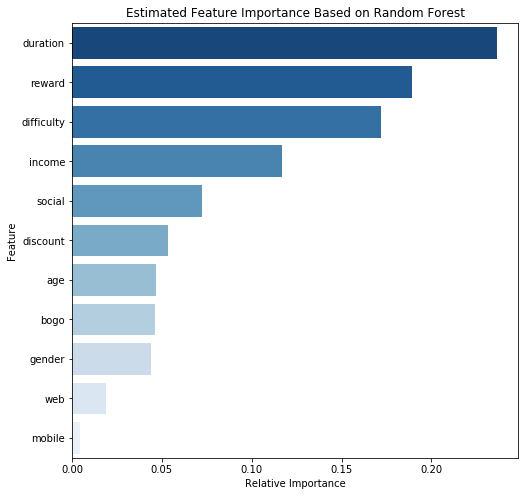

In [99]:
# Define variables
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(feature_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

# Plot Estimated Feature Importance
plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Estimated Feature Importance Based on Random Forest')

In [100]:
# Print the top features sorted based on their estimated importance
feature_importance.head(n=10)

,feature,relativeimportance
0,duration,0.236675
1,reward,0.189420
2,difficulty,0.171785
3,income,0.116658
4,social,0.072167
5,discount,0.053313
6,age,0.046955
7,bogo,0.045993
8,gender,0.043742
9,web,0.018675


> Feature importance refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. Random forest classifier is a model that estimates feature importance during training. The customer offer effectiveness training data suggests that the top five features based on their importance are:
1. Duration (how long offer runs before expiring)
2. Reward (stars earned by customer when offer is redeemed) 
3. Difficulty (minimum spending required to redeem offer) 
4. Income
5. Social (advertisements on social media)

<a id='gb'></a>
## iv. Gradient Boosting Classifier

**Construct a Gradient Boosting classifier**

Gradient boosting builds trees one at a time, where each new tree helps correct errors made by the previously trained tree.

In [121]:
# Create the random grid
# https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/
gb_clf = GradientBoostingClassifier(random_state=42)

random_grid = {'loss': ['deviance', 'exponential'],
               'learning_rate': [0.1, 0.01, 0.001],
               'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}

gb_random = RandomizedSearchCV(estimator = gb_clf,
                               param_distributions = random_grid,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

gb_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   53.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

### **Evaluate Gradient Boosting Model Performance**

In [122]:
# Evaluate gradient boosting model performance
evaluate_model_performance(gb_random.best_estimator_, X_train, y_train)

GradientBoostingClassifier model accuracy: 0.713
GradientBoostingClassifier model f1-score: 0.716


(0.7130182599355531, 0.7160981829773668)

**Results**
* Results suggest that a gradient boosting model's accuracy and F1-score is better than the naive predictor
    * Accuracy
        * Naive predictor: 0.471
        * Gradient boosting: 0.713
    * F1-score
        * Naive predictor: 0.640
        * Gradient boosting: 0.716

### Model ranking summary
* Model ranking based on training data accuracy:
    1. GradientBoostingClassifier model accuracy: 0.713
    2. RandomForestClassifier model accuracy: 0.711
    3. LogisticRegression model accuracy: 0.696
    4. Naive predictor accuracy: 0.471
* Model ranking based on training data f1-score:
    1. RandomForestClassifier model f1-score: 0.723
    2. GradientBoostingClassifier model f1-score: 0.716
    3. LogisticRegression model f1-score: 0.691
    4. Naive predictor f1-score: 0.640
    
>Results suggest that the gradient boosting model has the best accuracy and random forest model has the best f1-score.

### Selecting the best model

**Accuracy & F1-score**

In an ideal scenario, the best model should have the highest [accuracy and f1-score](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/). Since this isn't the case, let's evaluate the two performance metrics to determine the best model for tuning and refinement:
* Accuracy is the ratio of correctly predicted observations to total observations. A high accuracy is not necessarily indicative of the best model. Accuracy is best when evaluating symmetric datasets where values of false positives and false negatives are alomst the same. Additional parameters are needed to evaluate the best model. For our gradient boosting model, the accuracy is 0.713 which means the model is approximately 71.3% accurate.
* F1-score is the weighted average of precision (correctly predicted positive observations / predicted positive observations + total predicted positive observations) and recall (correctly predicted positive observations / all observations + total false negative observations). Since the f1-score takes both false positives and false negatives into account, it is usually more accurate. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it's better to look at the f1-score since it contains both precision and recall.



**Model comparison**

* A **[logistic regression model](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)** constructs a linear decision boundary to separate successful and unsuccessful offers. However, the exploratory analysis of user demographics and offer types suggests a non-linear decision boundary. For this reason the ensemble methods, random forest and gradient boosting, were tested and expected to perform better.
* Both **[random forest and gradient boosting classifiers](https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80)** use multiple decision trees. Gradient boosting builds trees one at a time, where each new tree helps correct errors made by the previously trained tree. Random forest trains each tree independently, using a random sample of the data. 
    * **Strengths**
        * *Gradient boosting:*
            * High-performing
            * Can be used to solve almost all objective functions including things like ranking and poisson regression, which is harder to achieve in random forest classification
        * *Random forest:*
            * Much easier to tune since there are typically two parameters (number of trees and number of features to be selected at each node)
            * Less likely to overfit model
    * **Weaknesses:**
        * *Gradient boosting:*
            * More sensitive to overfitting especially with noisy data
            * Training takes longer since trees are built sequentially
            * Harder to tune than random forest since there are typically three parameters (number of trees, depth of trees and learning rate)
        * *Random forest:*
            * Slow for real-time prediction due to large number of trees
            * Not reliable for data that includes categorical variable (biased in favor of attributes with more levels)
            * Not reliable for data that contains groups of correlated features (algorithm favors smaller groups over larger groups)
          
> Since the user data in this analysis is not symmetric, the f1-score will be used to determine the best model. Given the best f1-score, **the random forest model will be used as the best model for the remainder of this analysis**. This model also makes the most sense since the random forest typically results in very high quality models that are fast to train. Random forest can handle a large amount of training data efficiently and inherently so it is well suited for future use with multi-class problems given big data from Starbucks' [13 million](https://www.forbes.com/sites/bernardmarr/2018/05/28/starbucks-using-big-data-analytics-and-artificial-intelligence-to-boost-performance/#266d9d8a65cd) active users.

<a id='tune'></a>
## v. Tuning Parameter Refinement

**Build dataframe of models ranked by performance**

In [124]:
# Build df of ranked model performance
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
model_performance = []

classifier_type = ['naivepredictor','logisticregression','randomforest','gradientboosting']

model_performance.append((naive_predictor_accuracy, naive_predictor_f1score))

model_performance.append(evaluate_model_performance(lr_random.best_estimator_, X_train, y_train))

model_performance.append(evaluate_model_performance(rf_random.best_estimator_, X_train, y_train))

model_performance.append(evaluate_model_performance(gb_random.best_estimator_, X_train, y_train))

model_performance = pd.DataFrame(model_performance, columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type, columns=['classifiertype'])

model_performance = pd.concat([classifier_type, model_performance], axis=1)

model_performance = model_performance.sort_values('f1score', ascending=False)
model_performance = model_performance.reset_index(drop=True)
model_performance

LogisticRegression model accuracy: 0.696
LogisticRegression model f1-score: 0.691
RandomForestClassifier model accuracy: 0.711
RandomForestClassifier model f1-score: 0.723
GradientBoostingClassifier model accuracy: 0.713
GradientBoostingClassifier model f1-score: 0.716


,classifiertype,accuracy,f1score
0,randomforest,0.710934,0.723093
1,gradientboosting,0.713018,0.716098
2,logisticregression,0.695639,0.691167
3,naivepredictor,0.470763,0.640161


**Print the best model's hyperparameters**

In [183]:
# Print the best model's hyperparameters
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


**Refine model hyperparameter space**

In [190]:
# Refine model hyperparameter space
parameters = {'n_estimators': [300, 350, 400, 450, 500],
              'max_depth': [10, 11, 12, 13, 14, 15],
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'random_state': [42]}

grid_obj = GridSearchCV(rf_clf, 
                        parameters, 
                        scoring=scorer, 
                        cv=5, 
                        n_jobs=3, 
                        verbose=2)

grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Evaluate model performance
evaluate_model_performance(best_clf, X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 21.5min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 39.6min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 65.5min
[Parallel(n_jobs=3)]: Done 1350 out of 1350 | elapsed: 98.9min finished


RandomForestClassifier model accuracy: 0.824
RandomForestClassifier model f1-score: 0.881


(0.8236949516648765, 0.8813623024993857)

**Print the Refined Random Forest Model's Hyperparameters**

In [191]:
# Print the refined random forest model's hyperparameters
best_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Evaluate Test Data Performance**

In [192]:
# Evaluate model performance
evaluate_model_performance(best_clf, X_test, y_test)

RandomForestClassifier model accuracy: 0.695
RandomForestClassifier model f1-score: 0.797


(0.69530349355922, 0.7965460691455538)

<a id='conclusion'></a>
# 7. Conclusion

<a id='results'></a> 
## i. Results

This project focused on two parts: identifying customer spending trends and building a model to predict customer response to an offer.

**Part 1 - The analysis of transaction, offers, and customer demgraphic data revealed the following:**
>* **Starbucks user demographics:**
    * 57% of users are males, 41% are females, and 1.4% are other genders. While the majority of users are males, females spend more with average expenses totalling to 140.91 USD. Total spending average for other genders is 124.32 USD and 99.59 USD and for males.   
    * Majority of users in this dataset are in the 50-70 year age group. As age increases, users spend more.
    * The 55,000-78,000 USD salary range is most common amongst users in the dataset. Customers with greater income spend more.
* **Starbucks offer performance:**
    * Of the three offer types (BOGO, discount, informational), the BOGO promotions returned the greatest income of 138.43 USD in average earnings per customer. The discount promotions returned an average of 135.23 USD and informational offers averaged at 113.74 USD per customer.
    * The customer offer effectiveness training data suggests that the top five features based on their importance are:
        1. Duration (how long offer runs before expiring)
        2. Reward (stars earned by customer when offer is redeemed) 
        3. Difficulty (minimum spending required to redeem offer) 
        4. Income
        5. Social (advertisements on social media)
* **Customer behavior based on demographics:**
    * Females spent the most per transaction in all offer categories
    * Average transaction value increased with increasing age and declined past 75 years in all promotional categories
    * Customers with greater income spent more per transaction in all three offer types


      
  
**Part 2 - The process of building the offer success prediction model:**
>1. Offer portfolio, customer profiles, and transaction data were merged into a single dataframe for modeling. The accuracy and f1-score of the naive model were assessed. 
2. Logistic regression, random forest, and gradient boosting models were built and their performance metrics were evaluated. 
3. Random forest classifier was selected as the best model based on performance metrics, high quality output, and the ability to quickly train this model. Random forest can handle a large amount of training data efficiently and inherently so it is well suited for future use with multi-class problems from Starbucks' [13 million](https://www.forbes.com/sites/bernardmarr/2018/05/28/starbucks-using-big-data-analytics-and-artificial-intelligence-to-boost-performance/#266d9d8a65cd) active users. 
4. The random forest classifier model was then refined using hyperparameters from grid search. Analyses reveal that the resulting random forest model has a training data accuracy of 0.824 and an f1-score of 0.881. The test data accuracy of 0.695 and f1-score of 0.797 suggests that the random forest model constructed did not overfit the training data.

<a id='recs'></a> 
## ii. Recommendations

Analysis of results concludes the following recommendations:
>1. Starbucks should continue running discounts and BOGO promotions since they are redeemed by customers of all demographics, have a large percent success rate, and return high earnings. Informational offers fall in last place when looking at earnings, percent success, and feature importance. There is also no way to track whether informational offers are redeemed (can only see if user received or opened informational offer). Based on these results, I would suggest that Starbucks only continue BOGO and discount offers. Informational offers should instead be viewed as an advertisement since there are no measurable properties to track earnings that are comparable to BOGO and discount offers. 
2. To maximize average transaction earnings, Starbucks should target females, age groups of 40 and above, and users with salaries of 60k and higher. 
3. Starbucks should use the random forest classifier model built to predict whether or not a customer will respond to an offer. This will minimize the use of resources and expenses involved in launching an offer and increase the likelihood of maximum return. 

<a id='ce'></a> 
## iii. Continued Exploration

Recommended areas for further exploration to implement data-driven processes and increase earnings:
>* **Customer data:**
    * Customer spending is greater with increasing age and income. It might be worth exploring whether Starbucks should increase the frequency of promotions based on age and salary. Since females spend more than all other genders, it would also be interesting to explore the reasoning behind these higher numbers. 
        * i.e. Do females buy higher priced items? Do they purchasing more frequently? Are they buying more items? Is there any implication that they're purchasing for a group of individuals?
* **Random forest model:**
    * Since the top three features are associated with customer offers, the model could be improved by creating features that describe an offer's success rate as a function of offer duration, difficulty, and reward. The addition of these features should construct a better decision boundary of separating successful and unsuccessful customer offers, returning a model with more reliable performance metrics.

<a id='limitations'></a>
# 8. Limitations

Limitations to consider when reviewing this report:
>* **Simplified datasets**
    * The datasets used in this project are simplified versions of the real Starbucks app. The underlying simulator only has one product whereas Starbucks sells dozens.
* **Discrepancies in linking transactions to redeemed offers**  
    * Customers do not opt into the offers that they receive. Someone using the app might make a purchase through the app without having received or seen an offer. There is also no way to track whether informational offers are redeemed (can only see if user received or opened informational offer).
* **Results are not indicative of user behavior at the individual level** 
    * Users receive different promotions, frequency varies, and some may not receive offers for a longer period of time. The datasets used in the analysis do not factor in this variation. 
   

<a id='source'></a>
# 9. Source Index

* https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
* https://www.forbes.com/sites/bernardmarr/2018/05/28/starbucks-using-big-data-analytics-and-artificial-intelligence-to-boost-performance/#266d9d8a65cd
* https://www.geeksforgeeks.org/seaborn-barplot-method-in-python/
* https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data
* https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
* https://machinelearningmastery.com/calculate-feature-importance-with-python/
* https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/
* https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80
* https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
* https://python-graph-gallery.com/100-calling-a-color-with-seaborn/
* https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
* https://seaborn.pydata.org/tutorial/distributions.html
* https://seaborn.pydata.org/generated/seaborn.distplot.html
* https://seaborn.pydata.org/examples/distplot_options.html
* https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy
* https://stackoverflow.com/questions/49059956/pandas-plot-value-counts-barplot-in-descending-manner
* https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis
* https://stackoverflow.com/questions/11244514/modify-tick-label-text
* https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots-with-matplotlib
* https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
* https://stackoverflow.com/questions/48749972/combine-line-and-histogram-in-matplotlib?noredirect=1&lq=1
* https://stackoverflow.com/questions/3777861/setting-y-axis-limit-in-matplotlib
* https://stackoverflow.com/questions/41433983/python-pandas-lambda-using-multiple-variables-lambda-within-dataframe
* https://stackoverflow.com/questions/19851005/rename-pandas-dataframe-index
* https://stackoverflow.com/questions/41118359/aggregate-values-in-dictionary-by-key
* https://stackoverflow.com/questions/46481351/how-to-round-numbers-to-the-nearest-1000
* https://stackoverflow.com/questions/25740726/how-to-aggregate-elements-of-a-list-of-tuples-if-the-tuples-have-the-same-first
* https://stackoverflow.com/questions/37978542/plot-multiple-functions-with-the-same-properties-in-matplotlib
* https://stackoverflow.com/questions/5997987/is-there-an-operator-to-calculate-percentage-in-python
* https://stackoverflow.com/questions/46768859/how-to-change-the-default-colors-for-multiple-plots-in-matplotlib
* https://www.starbucks.com/
* https://www.starbucks.com/coffeehouse/mobile-apps
* https://towardsdatascience.com/combo-charts-with-seaborn-and-python-2bc911a08950
* https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce
* https://towardsdatascience.com/uplift-modeling-e38f96b1ef60
* https://www.ritchieng.com/machine-learning-evaluate-classification-model/
* https://www.udacity.com/course/data-scientist-nanodegree